In [17]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from collections import namedtuple

from pa_lib.file import (
    project_dir,
    load_bin,
    write_xlsx,
    store_bin,
)
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect, value, flatten, normalize_rows, normalize_cols, list_items
from pa_lib.log import time_log

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [18]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data_enriched.feather")
    ax_var_struct = load_bin("ax_var_struct.feather")
    
Variable = namedtuple("Variable", ["Label", "Codes", "Order"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(data["Variable_Label"].max(), data["Label"].to_list(), data["Label_Nr"].to_list())

17:21:24 [INFO] Started loading binary file ...
17:21:24 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data_enriched.feather
17:21:24 [INFO] ... finished loading binary file in 0.38s (0.72s CPU)
17:21:24 [INFO] Started loading binary file ...
17:21:24 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_struct.feather
17:21:24 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)


In [19]:
def var_label(variable):
    return var_info[variable].Label


def var_codes(variable):
    return var_info[variable].Codes

In [20]:
weekday_order = ax_data["DayOfWeek"].cat.categories.to_list()
workdays = weekday_order[:5]
weekend = weekday_order[5:]

timeSlot_order = ax_data["TimeSlot"].cat.categories.to_list()
day = timeSlot_order[1:]
rush_hours = list_items(timeSlot_order, [1, 5])
day_no_rush = list_items(timeSlot_order, [2, 3, 4, 6])

stations_d = [
    "Aarau",
    "Basel SBB",
    "Bern",
    "Biel/Bienne",
    "Brig",
    "Chur",
    "Luzern",
    "Olten",
    "St. Gallen",
    "Winterthur",
    "Zug",
    "Zürich Enge",
    "Zürich Flughafen",
    "Zürich Flughafen - Airside",
    "Zürich Flughafen - Landside",
    "Zürich HB",
    "Zürich Hardbrücke",
    "Zürich Oerlikon",
    "Zürich Stadelhofen",
]
stations_f = [
    "Biel/Bienne",
    "Fribourg",
    "Genève Aéroport",
    "Genève Cornavin",
    "Lausanne",
    "M2",
    "Neuchatel",
]
stations_i = ["Bellinzona", "Lugano"]

In [21]:
ax_data.head()

,Station,DayOfWeek,Time,Variable,Code,Value,Year,Month,logValue,VarDesc,TimeSlot,Hour,Label_Nr,is_weekend,is_day,is_rush,is_day_no_rush,TimeSlot_cat,StationSprache
0,Aarau,Monday,00:15 - 00:30,g_220,Keines,0.954451,2019,05,-0.046619,Anzahl Autos im Haushalt,Nacht,00,1,False,False,False,False,Night,Deutsch
1,Aarau,Monday,00:15 - 00:30,g_500,quoted,0.954451,2019,05,-0.046619,Zeitung: 20 Minuten / 20 Minutes / 20 Minuti,Nacht,00,2,False,False,False,False,Night,Deutsch
2,Aarau,Monday,00:15 - 00:30,g_501,not quoted,0.954451,2019,05,-0.046619,Zeitung: Blick,Nacht,00,1,False,False,False,False,Night,Deutsch
3,Aarau,Monday,00:15 - 00:30,g_502,not quoted,0.954451,2019,05,-0.046619,Zeitung: Tages-Anzeiger,Nacht,00,1,False,False,False,False,Night,Deutsch
4,Aarau,Monday,00:15 - 00:30,g_503,not quoted,0.954451,2019,05,-0.046619,Zeitung: Mittelland Zeitung,Nacht,00,1,False,False,False,False,Night,Deutsch


# Define functions

## Select data

In [22]:
def _check_selection(data, selection, allowed_columns):
    allowed_values = {}
    for column in allowed_columns:
        allowed_values[column] = data[column].cat.categories
    if set(selection.keys()) - set(allowed_columns) != set():
        raise NameError(f"Unknown column name in selection: {selection.keys()}")
    clean_selection = {}
    for column in allowed_columns:
        if column in selection:
            col_values = list(flatten(selection[column]))
            if set(col_values) - set(allowed_values[column]) != set():
                raise ValueError(f"Illegal value(s) in parameter {column}: {col_values}")
            clean_selection[column] = col_values
        else:
            clean_selection[column] = None
    return clean_selection


def select_data(all_data, **selection):
    select_columns = "DayOfWeek Station Variable Month TimeSlot Hour Time TimeSlot_cat StationSprache".split()
    selection = _check_selection(all_data, selection, allowed_columns=select_columns)
    row_mask = pd.Series([True] * all_data.shape[0])
    for col in select_columns:
        if selection[col] is not None:
            row_mask &= all_data[col].isin(selection[col])
    return all_data.loc[row_mask].pipe(clean_up_categoricals).reset_index(drop=True)

In [10]:
select_data(ax_data, DayOfWeek="Monday", Station="Aarau")

,Station,DayOfWeek,Time,Variable,Code,Value,Year,Month,logValue,VarDesc,TimeSlot,Hour,Label_Nr,is_weekend,is_day,is_rush,is_day_no_rush,TimeSlot_cat,StationSprache
0,Aarau,Monday,00:15 - 00:30,g_220,Keines,0.954451,2019,05,-0.046619,Anzahl Autos im Haushalt,Nacht,00,1,False,False,False,False,Night,Deutsch
1,Aarau,Monday,00:15 - 00:30,g_500,quoted,0.954451,2019,05,-0.046619,Zeitung: 20 Minuten / 20 Minutes / 20 Minuti,Nacht,00,2,False,False,False,False,Night,Deutsch
2,Aarau,Monday,00:15 - 00:30,g_501,not quoted,0.954451,2019,05,-0.046619,Zeitung: Blick,Nacht,00,1,False,False,False,False,Night,Deutsch
3,Aarau,Monday,00:15 - 00:30,g_502,not quoted,0.954451,2019,05,-0.046619,Zeitung: Tages-Anzeiger,Nacht,00,1,False,False,False,False,Night,Deutsch
4,Aarau,Monday,00:15 - 00:30,g_503,not quoted,0.954451,2019,05,-0.046619,Zeitung: Mittelland Zeitung,Nacht,00,1,False,False,False,False,Night,Deutsch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41403,Aarau,Monday,23:45 - 00:00,md_tv,1 oder mehrere TV-Geräte,1.015517,2019,08,0.015398,TV im Haushalt,Nacht,23,2,False,False,False,False,Night,Deutsch
41404,Aarau,Monday,23:45 - 00:00,md_upc,not quoted,1.015517,2019,08,0.015398,UPC Prepaid/Abo,Nacht,23,1,False,False,False,False,Night,Deutsch
41405,Aarau,Monday,23:45 - 00:00,md_wohneigentum,Mieter,1.015517,2019,08,0.015398,Eigentümer versus Mieter,Nacht,23,2,False,False,False,False,Night,Deutsch
41406,Aarau,Monday,23:45 - 00:00,md_zivil,ledig,1.015517,2019,08,0.015398,Zivilstand,Nacht,23,2,False,False,False,False,Night,Deutsch


## Display selection as pivot table (Codes vs. Time) and heatmap

In [23]:
from scipy.stats import chi2_contingency


def _cont_table(var, data, index_by, aggfunc):
    all_codes = var_codes(var)
    observed_codes = (
        pd.Series(all_codes)
        .loc[pd.Series(all_codes).isin(data["Code"].unique())]
        .values
    )
    cont_table = data.pivot_table(
        index=index_by,
        columns="Code",
        values="Value",
        aggfunc=aggfunc,
        margins=False,
        fill_value=0,
    ).loc[:, observed_codes]
    return cont_table


def _show_chisq(var, actual, counts, resid_type):
    (_, p_val, _, expected) = chi2_contingency(actual)
    if resid_type == "absolute":
        residuals = actual - expected
    elif resid_type == "percent":
        residuals = (actual / expected * 100) - 100
    else:
        raise ValueError(
            f"Parameter resid_type not in ('absolute', 'percent') ('{resid_type}')"
        )
    (plot_rows, plot_cols) = residuals.shape
    plt.figure(figsize=(plot_cols * 2, plot_rows))
    plt.title(f"Abweichung: {var_label(var)} ({var}), p={round(p_val, 4)}", pad=12)
    annotations = residuals.round(1).values
    sns.heatmap(
        data=residuals,
        center=0,
        annot=annotations,
        linewidths=0,
        robust=True,
        fmt=".1f",
    )


def show_code_cont_tables(
    selection,
    index_by,
    aggfunc="sum",
    show_agg=True,
    show_normal=False,
    show_chisq=False,
    chisq_resid="absolute",
):
    data = select_data(ax_data, **selection)
    for var, subset in data.groupby("Variable"):
        # calculate contingency table
        prop_table = _cont_table(var, subset, index_by, aggfunc)
        count_table = _cont_table(var, subset, index_by, aggfunc="size")

        # show results
        if show_agg or show_normal:
            print(f"Variable: {var_label(var)} ({var})")
            print(
                "Selection: "
                + ", ".join(f"{col} = {values}" for col, values in selection.items())
            )
        if show_agg:
            display(prop_table.round(1))
        if show_normal:
            print("Code percentages:")
            display(normalize_rows(prop_table).round(3) * 100)
        if show_chisq:
            _show_chisq(
                var,
                actual=prop_table,
                counts=count_table,
                resid_type=chisq_resid,
            )

Variable: Haushaltsbruttoeinkommen pro Monat (md_ek)
Selection: DayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], Station = Zürich HB, Variable = ['md_ek', 'md_hhverm']


Code,Keine Angabe,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF,Mehr als 12'000 CHF
TimeSlot,,,,,,,
Nacht,98.2,40.3,30.4,94.7,208.8,129.9,315.1
Morgen-Rush,523.0,364.5,204.2,483.3,1198.3,1188.1,2144.9
Morgen,209.2,119.7,189.7,262.6,508.2,615.9,580.8
Mittag,381.2,141.5,164.4,264.0,600.1,631.3,687.0
Nachmittag,402.9,250.4,287.1,302.0,935.0,916.7,992.1
Abend-Rush,874.1,520.7,507.5,680.4,2137.2,1944.8,2608.6
Abend,454.2,331.9,373.6,539.8,1064.1,854.9,1145.6


Variable: frei verfügbares Vermögen Haushalt (md_hhverm)
Selection: DayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], Station = Zürich HB, Variable = ['md_ek', 'md_hhverm']


Code,Keine Angabe,Weniger als CHF 50 000,Zwischen CHF 50 000 und CHF 100 000,Zwischen CHF 100 000 und CHF 250 000,Zwischen CHF 250 000 und CHF 500 000,Zwischen CHF 500 000 und CHF 1 Mio.,Zwischen CHF 1 Mio. und CHF 5 Mio.,Mehr als CHF 5 Mio.
TimeSlot,,,,,,,,
Nacht,251.8,206.2,117.4,206.8,57.4,17.7,32.6,8.6
Morgen-Rush,1349.9,1938.2,905.8,912.4,786.1,50.0,109.2,13.8
Morgen,647.6,622.6,428.1,393.2,227.2,53.2,54.5,14.7
Mittag,726.0,798.3,473.8,278.7,295.4,97.4,115.8,17.8
Nachmittag,906.2,1106.7,688.0,573.4,443.8,130.1,117.1,21.4
Abend-Rush,2204.7,2692.8,1595.3,1183.4,932.9,228.1,230.4,39.3
Abend,1017.8,1566.3,846.8,552.0,319.1,145.3,137.2,55.8


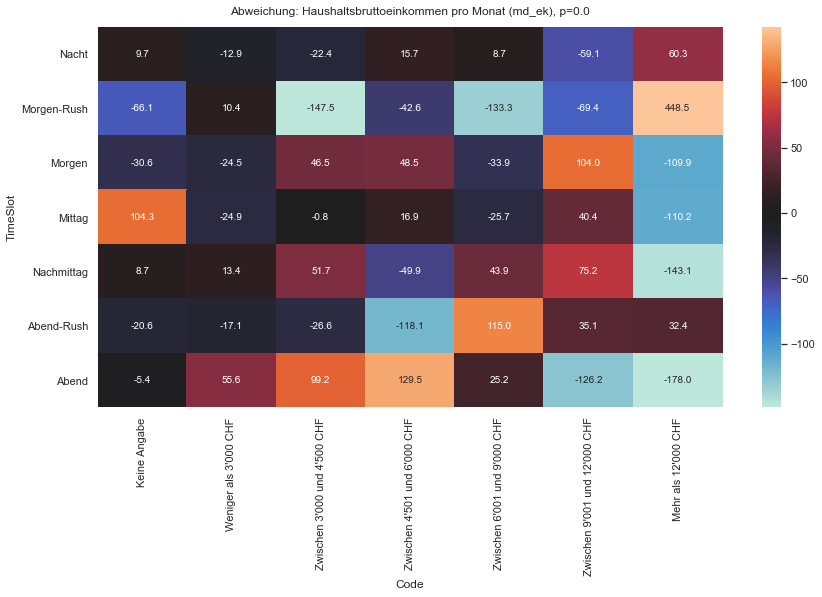

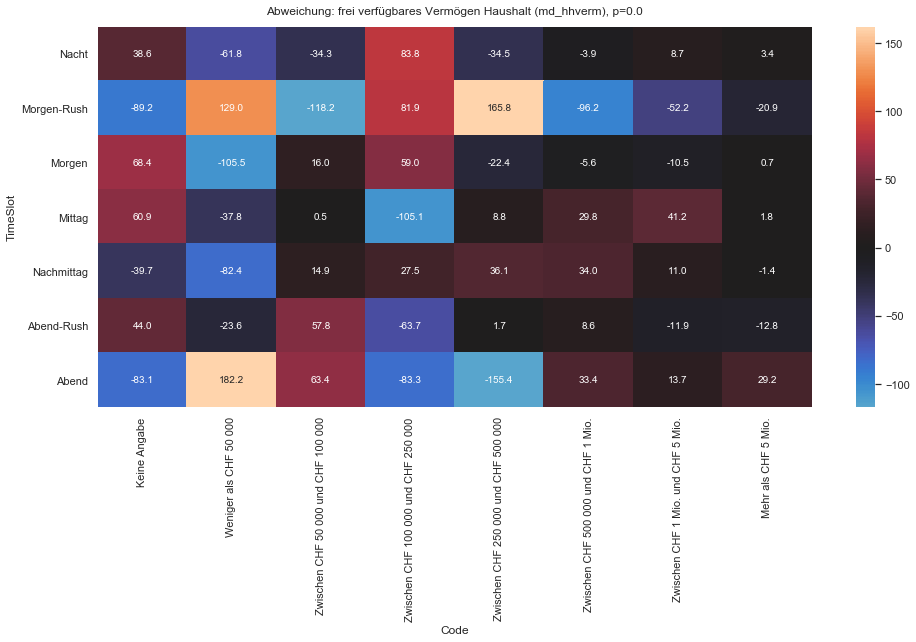

In [24]:
def _per_quarter(s):
    return s.sum() / s.size

def _extrapolate(s):
    return _per_quarter(s) * 4250 

show_code_cont_tables(
    selection=dict(
        DayOfWeek=workdays,
        Station="Zürich HB",
        Variable=["md_ek", "md_hhverm"],
    ),
    index_by=["TimeSlot"],
    aggfunc="sum",
    show_chisq=True,
    chisq_resid="absolute",
)

## Estimate cell median and confidence intervals (quantiles)

In [25]:
from scipy.stats import chi2_contingency


def var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result

In [26]:
def interval(s):
    try:
        (q25, med, q75) = np.percentile(s, [25, 50, 75])
        iqr = q75 - q25
        #return [q25 - 1.5 * iqr, med, q75 + 1.5 * iqr]  # Tukey's outlier limits
        return [q25, med, q75]  # quartiles
    except:
        return -1

In [27]:
selection = dict(
    DayOfWeek=workdays,
    Variable=["md_ek"],
    Station=stations_d,
)

show_code_cont_tables(selection, index_by="TimeSlot", aggfunc=interval)

Variable: Haushaltsbruttoeinkommen pro Monat (md_ek)
Selection: DayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], Variable = ['md_ek'], Station = ['Aarau', 'Basel SBB', 'Bern', 'Biel/Bienne', 'Brig', 'Chur', 'Luzern', 'Olten', 'St. Gallen', 'Winterthur', 'Zug', 'Zürich Enge', 'Zürich Flughafen', 'Zürich Flughafen - Airside', 'Zürich Flughafen - Landside', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Oerlikon', 'Zürich Stadelhofen']


Code,Keine Angabe,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF,Mehr als 12'000 CHF
TimeSlot,,,,,,,
Nacht,"[0.920626087, 1.052128814, 1.232617544]","[1.052128814, 1.1161584759999998, 1.3912666669999998]","[0.9110237290000001, 1.052128814, 1.124689091]","[1.001383051, 1.232617544, 1.44976]","[0.9227944440000001, 1.043227273, 1.4350049999999999]","[0.9003234040000001, 1.0447206365000001, 1.431078261]","[0.920626087, 1.046214, 1.8133872340000001]"
Morgen-Rush,"[0.9371363640000001, 1.4350049999999999, 2.5004571419999997]","[0.959182222, 1.229744, 2.104257628]","[1.03611375, 1.2502285709999998, 2.07664302225]","[0.982104938, 1.423234783, 2.304681053]","[1.011073585, 1.7994271780000002, 3.0238080472499997]","[0.9544509090000001, 1.7320014615, 2.917270458]","[1.011073585, 1.9376603780000001, 3.4232]"
Morgen,"[0.90576, 1.112141026, 1.684446429]","[0.951608696, 1.0579271190000001, 1.423234783]","[1.0038056845, 1.223973163, 1.573772973]","[0.910211765, 1.05315, 1.7387939399999999]","[0.931509783, 1.209624324, 2.06782380925]","[0.927163077, 1.164718033, 2.1162813335]","[0.9333, 1.232617544, 2.112592886]"
Mittag,"[0.919454545, 1.124689091, 1.994634641]","[0.9053627877499999, 1.0559716780000001, 1.305821739]","[0.931509783, 1.124689091, 1.737259259]","[0.910211765, 1.0656214290000001, 1.8526457079999998]","[0.9333, 1.261542857, 2.2219311735]","[0.931509783, 1.1871191490000002, 2.240351852]","[0.9227944440000001, 1.218202326, 2.109547942]"
Nachmittag,"[0.910211765, 1.099130667, 1.77640851]","[0.969351724, 1.120175926, 1.682057142]","[0.9333, 1.1088675, 1.74061017]","[0.9052851059999999, 1.0757373129999999, 1.81780188175]","[0.931509783, 1.2502285709999998, 2.1063]","[0.920626087, 1.1806127659999999, 2.0957534730000003]","[0.9371363640000001, 1.267851852, 2.278188651]"
Abend-Rush,"[0.970735714, 1.4611666665, 2.4637431867499995]","[0.969351724, 1.124689091, 2.0392616185]","[0.9798396229999999, 1.124689091, 1.9894369019999998]","[0.9544509090000001, 1.3912666669999998, 2.198261334]","[1.021275, 1.863019566, 3.1084423077499994]","[0.957820755, 1.792307534, 3.08153163325]","[1.05315, 1.98363173, 3.622383332]"
Abend,"[0.920626087, 1.0579271190000001, 1.684446429]","[0.9725, 1.0579271190000001, 1.301959184]","[1.052128814, 1.120175926, 1.8012102685000002]","[0.9222523547500001, 1.056064286, 1.4586]","[0.951608696, 1.1576799999999998, 2.094040869]","[0.9066936170000001, 1.109274324, 1.903217392]","[0.931509783, 1.1871191490000002, 2.03922994]"


## Visualize estimations with confidence intervals

In [44]:
def plot_estimates(data, target, time_scale, plot_kind, heatmap_aggr="sum", heatmap_display_table=False, heatmap_norm=None):

    def _calc_heatmap(data, columns, **kwargs):
        heatmap = data.pivot_table(
            values=target, 
            index=time_scale, 
            columns="Code", 
            aggfunc=heatmap_aggr, 
            fill_value=0, 
            observed=True,
            **kwargs,
        )
        if heatmap_norm == "Time":
            heatmap = normalize_rows(heatmap) * 100
        elif heatmap_norm == "Code":
            heatmap = normalize_cols(heatmap) * 100
        elif heatmap_norm == "both":
            heatmap = heatmap / heatmap.values.sum() * 100
        elif heatmap_norm is not None:
            raise ValueError(f"Parameter heatmap_norm must be one of [None, 'Time', 'Code', 'both'], is '{heatmap_norm}'")
        heatmap_cols = list(filter(lambda col: col in heatmap.columns, columns))
        return heatmap.loc[:, heatmap_cols]
    
    for (var, data_subset) in data.groupby("Variable"):
        if plot_kind == "box":
            grid = sns.FacetGrid(data_subset, col=time_scale, col_wrap=3, height=4, aspect=1.5)
            grid.map(sns.boxenplot, "Code", target, order=var_codes(var))
            grid.fig.tight_layout(w_pad=1)
        elif plot_kind == "bar":
            grid = sns.FacetGrid(data_subset, col=time_scale, col_wrap=3, height=4, aspect=1.5)
            grid.map(sns.barplot, "Code", target, order=var_codes(var), ci=100)
            grid.fig.tight_layout(w_pad=1)
        elif plot_kind == "heatmap":
            plot_values = _calc_heatmap(
                data=data_subset,
                columns=var_codes(var),
            )
            (plot_rows, plot_cols) = plot_values.shape
            plt.figure(figsize=(plot_cols * 2, plot_rows))
            plt.title(f"{heatmap_aggr} of {var_label(var)} ({var})", pad=12)
            annotations = plot_values.round(1).values
            sns.heatmap(
                data=plot_values,
                center=0,
                annot=annotations,
                linewidths=0,
                robust=True,
                fmt=".1f",
            )
            if heatmap_display_table:
                display(
                    _calc_heatmap(
                        data=data_subset,
                        columns=var_codes(var) + ["Total"],
                        margins=True,
                        margins_name="Total",
                    ).round(1)
                )
        else:
            raise ValueError("Unknown plot_kind")

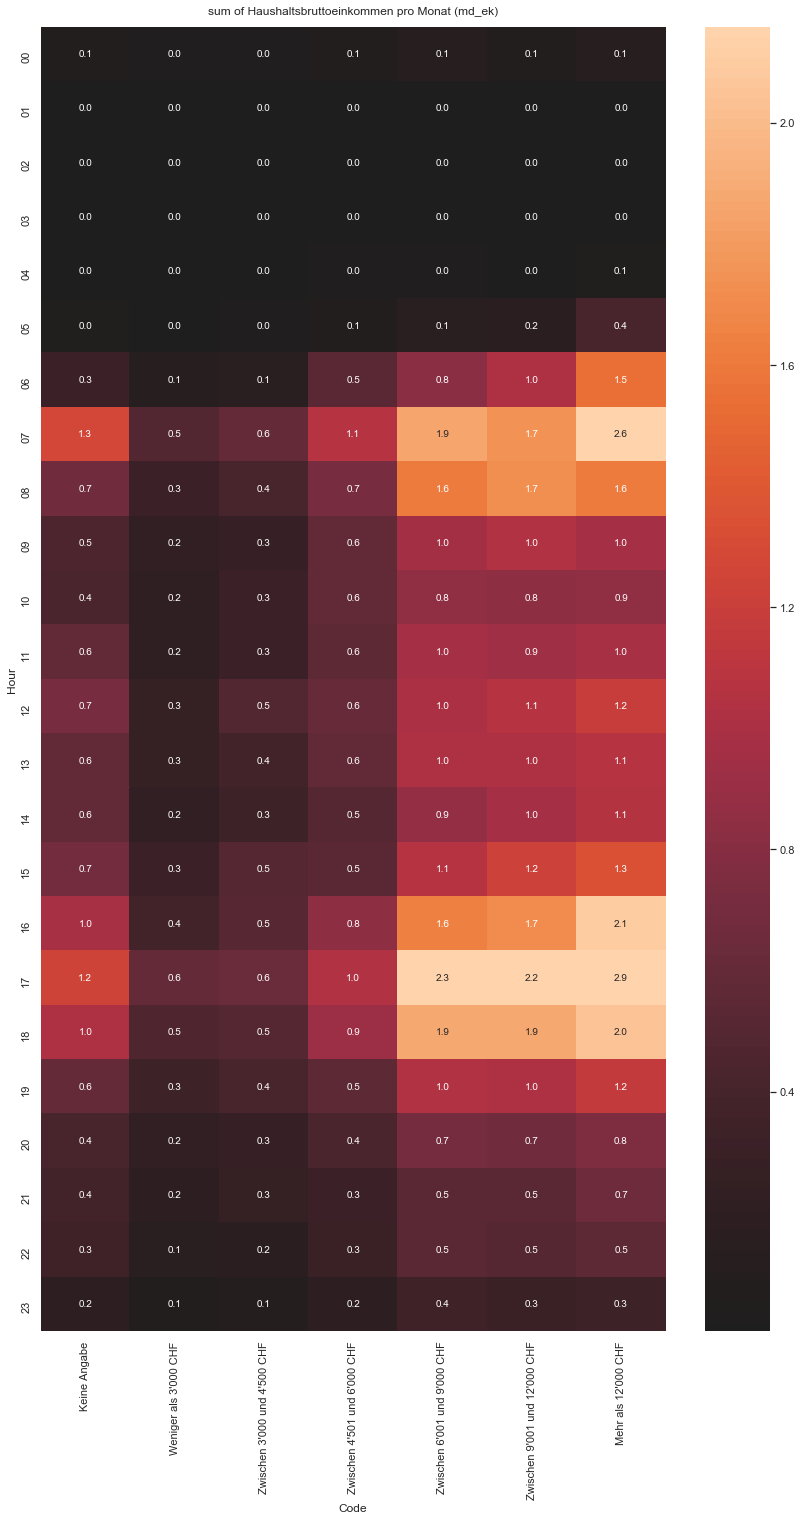

In [46]:
selection = dict(
    #Station=stations_d, 
    Variable=["md_ek"], 
    DayOfWeek=workdays,
)

plot_estimates(
    data=select_data(ax_data, **selection), 
    target="Value",
    time_scale="Hour",
    plot_kind="heatmap",
    heatmap_aggr="sum",
    heatmap_display_table=False,
    heatmap_norm='both',
)